<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>DiaObject Sample Identification</b> <br>
Contact author: Melissa Graham <br>
Last verified to run: 2024-01-31 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** To use the DiaObject table parameters to identify a sample of time-variable objects of interest, and to investigate the forced photometry lightcurves of a specific object of interest with the ForcedSourceOnDiaObject table. **Adapted to use the dp02_dc2_catalogs_frdf catalogs produced at CC-IN2P3.**

**Skills:** Use the TAP service and the DP0.2 DiaObject and DiaSource tables.

**LSST Data Products:** TAP tables dp02_dc2_catalog_frdf.DiaObject, DiaSource, and ForcedSourceOnDiaObject.

**Packages:** lsst.rsp, astropy.cosmology, astropy.stats, numpy, matplotlib

**Credit:** Originally developed by Melissa Graham and the Rubin Community Science Team for Data Preview 0. Updated for ForcedSourceOnDiaObject by Ryan Lau.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to use the DiaObject table's lightcurve summary statistics to identify samples of objects for further study, and how to retrieve and plot lightcurves for DiaObjects of interest from the DiaSource table.

As an example, a sample of potential low-redshift Type Ia supernovae are identified and retrieved from the DiaObject table.

> **Notice:** This notebook does not produce a pure or complete sample of SNIa, just a sample of *potential well-sampled low-redshift* SNIa. This is decent enough to use as a demonstration, or a starting point for a more rigorous classification process.
Different science goals will have different requirements on sample identification.

There are three different types of catalogs built from the difference images:
1. `DiaSource`: astrometric and photometric measurements for sources detected with signal-to-noise ratio > 5 in the difference images.
2. `DiaObject`: derived summary parameters for `DiaSources` associated by sky location, including lightcurve statistics.
3. `ForcedSourceOnDiaObject`: point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the `DiaObject` table.

Learn more about the contents of the DiaObject, DiaSource, ForcedSourceOnDiaObjects tables in the <a href="https://dp0-2.lsst.io">DP0.2 Documentation</a>.

This notebook uses the Table Access Protocol (TAP) service to access the catalogs, but they are also available via the Butler.

### 1.1. Package Imports

**lsst.rsp:** The LSST Science Pipelines package for RSP functionality such as the TAP service (<a href="http://pipelines.lsst.io">pipelines.lsst.io</a>).

**astropy.cosmology:** An open-source package of cosmology tools (<a href="https://docs.astropy.org/en/stable/cosmology/index.html">the astropy cosmology documentation</a>).

**astropy.stats:** An open-source package of astronomy-related statistical tools, used in this notebook to look for outliers in the forced-source lightcurves.

In [5]:
import numpy
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import sigma_clipped_stats

from lsst.rsp import get_tap_service

### 1.2. Define functions and parameters

Start the TAP service.

In [6]:
service = get_tap_service("tap")

Set the cosmology to use with the astropy.cosmology package.

In [7]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Set a few parameters to use later, when plotting lightcurves.

In [8]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

## 2. Understand the DiaObject table's contents

**DiaSource Table:** Measurements for sources detected with a signal-to-noise ratio > 5 in the difference images (i.e., lightcurves).
Note that these measurements are not forced photometry at the locations of all DiaObjects, but detections only.

**DiaObject Table:** Summary parameters for DiaSources associated by coordinate (including lightcurve summary statistics).

Option to print all of the available column names for the DiaObject table.

In [9]:
# results = service.search("SELECT column_name from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs_frdf.DiaObject'")
# for column_name in results['column_name']:
#     print(column_name)

### 2.1. Review these descriptions for selected lightcurve summary statistics

The DiaObjects table includes the following lightcurve summary statistics, which are derived from the contents of the DiaSource table.

**nDiaSources:** The number of difference-image detections in any filter (i.e., number of DiaSources associated with a given DiaObject).
 
The following statistics are all based on _difference-image point source (PS) flux values_ for each filter [f].<br>
**[f]PSFluxMin:** The faintest flux. <br>
**[f]PSFluxMax:** The brightest flux. <br>
**[f]PSFluxMean:** The average flux. <br>
**[f]PSFluxSigma:** The standard deviation of the fluxes. <br>
**[f]PSFluxMAD:** The mean absolute deviation of the fluxes (i.e., the average distance from the mean). <br>
**[f]PSFluxChi2:** The Chi2 statistic for the scatter of the fluxes around the mean. <br>
**[f]PSFluxNdata:** The number of data points used to compute [f]PSFluxChi2. <br>
**[f]PSFluxSkew:** A measure of asymmentry in the distribution of fluxes about the mean (where 0 means symmetric). <br>
**[f]PSFluxStetsonJ:** A variability index developed for Cepheids (defined in <a href="https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S/abstract">Stetson 1996</a>). <br>
**[f]PSFluxPercentile05, 25, 50, 75, 95:** Derived from the cumulative distribution of flux values. <br>

The following statistics are all based on the _direct-image total (TOT) flux values_ for each filter [f]. <br>
**[f]TOTFluxMean:** The average flux.  <br>
**[f]TOTFluxSigma:** The standard deviation of the fluxes.  <br>

> **Notice:** The DP0.2 DiaObject table is missing some variability characterization parameters (<a href="https://dmtn-118.lsst.io">DMTN-118</a>) and host association parameters (<a href="https://dmtn-151.lsst.io">DMTN-151</a>) which will exist for future data releases.

### 2.2. Plot summary-statistic histograms for a random sample of DiaObjects

In order to learn a bit more about these lightcurve summary statistics, histograms of their values for a random selection of DiaObjects are plotted.

First, retrieve a random sample of DiaObjects. This query takes about 1.5 minutes.

In [10]:
results = service.search("SELECT TOP 100000 "
                         "ra, decl, diaObjectId, nDiaSources, "
                         "rPSFluxMin, rPSFluxMax, rPSFluxMean, rPSFluxSigma, "
                         "rPSFluxMAD, rPSFluxChi2, rPSFluxNdata, rPSFluxSkew, "
                         "rPSFluxStetsonJ, rPSFluxPercentile05, rPSFluxPercentile25, "
                         "rPSFluxPercentile50, rPSFluxPercentile75, rPSFluxPercentile95, "
                         "rTOTFluxMean, rTOTFluxSigma "
                         "FROM dp02_dc2_catalogs_frdf.DiaObject ")
DiaObjs = results.to_table()
del results

**Plot the number of DiaSources per DiaObject**

Plot the distribution of the number of DiaSources per DiaObject (i.e., the total number of difference-image detections in any filter; at left), and the distribution of the number of r-band DiaSources per DiaObject (at right).

Notice how the distribution is peaked at small numbers of DiaSources (or r-band detections) -- these are time-variable sources that were only detected in a few difference images, and are most likely to have a faint time-variable flux (e.g., high-_z_ supernovae that were only detectable for a short duration).

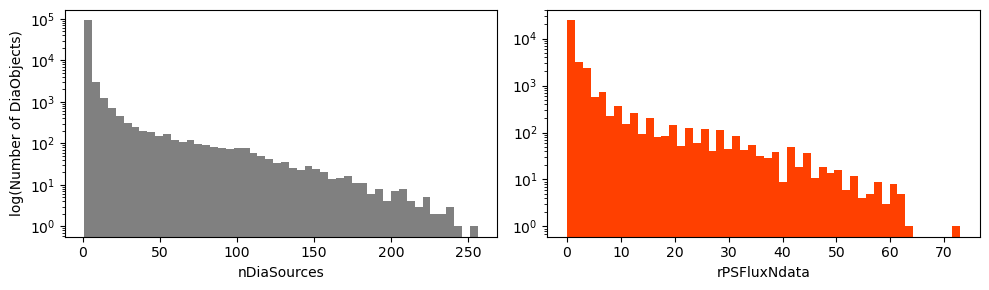

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['nDiaSources'], bins=50, log=True, color='gray')
ax[0].set_xlabel('nDiaSources')
ax[0].set_ylabel('log(Number of DiaObjects)')

ax[1].hist(DiaObjs['rPSFluxNdata'], bins=50, log=True, color=plot_filter_colors['r'])
ax[1].set_xlabel('rPSFluxNdata')

plt.tight_layout()
plt.show()

**Plot distributions of min/max PS fluxes**

Plot the distribution of minimum and maximum r-band PS flux from the difference-image detections.

Notice how the PS fluxes can be negative because they are measured on the difference images.
Any source that is fainter in the direct image than in the template image will be detected as a negative-flux source in the difference image. 

> **Warning:** Take care when converting difference-image fluxes into magnitudes, because they can be negative.

Notice how these distributions are peaked at low time-variable flux components -- likely the same types of faint sources which were only detectable for a short duration (as shown above).

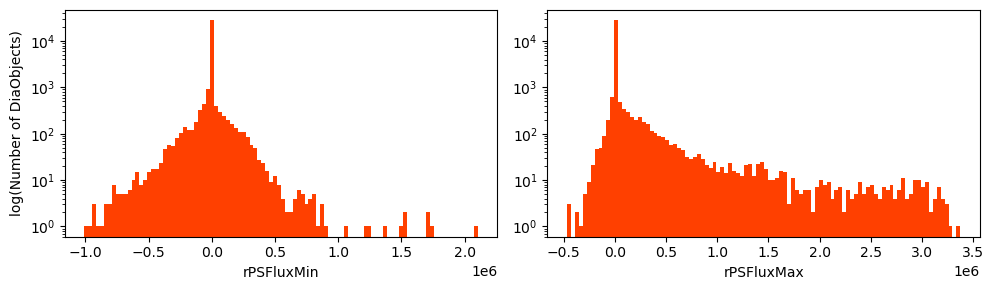

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['rPSFluxMin'], bins=100, log=True, color=plot_filter_colors['r'])
ax[0].set_xlabel('rPSFluxMin')
ax[0].set_ylabel('log(Number of DiaObjects)')

ax[1].hist(DiaObjs['rPSFluxMax'], bins=100, log=True, color=plot_filter_colors['r'])
ax[1].set_xlabel('rPSFluxMax')

plt.tight_layout()
plt.show()

**Confirm that DiaObjects with few DiaSources have min/max PS fluxes close to zero**

Plot the correlation between the number of r-band DiaSources per DiaObject, and the minimum (left) and maximum (right) difference-image PS flux values. 

Notice that it is, indeed, the fainter DiaObjects that have fewer DiaSource detections, as hypothesized above.

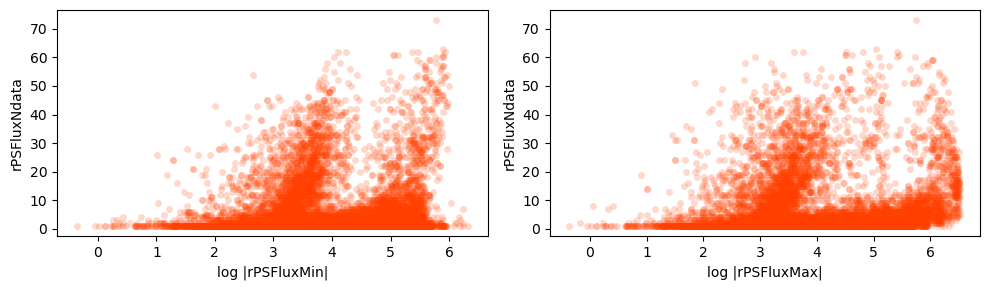

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].plot(numpy.log10(numpy.absolute(DiaObjs['rPSFluxMin'])),
           DiaObjs['rPSFluxNdata'],
           'o', ms=5, alpha=0.2, mew=0, color=plot_filter_colors['r'])
ax[0].set_xlabel('log |rPSFluxMin|')
ax[0].set_ylabel('rPSFluxNdata')

ax[1].plot(numpy.log10(numpy.absolute(DiaObjs['rPSFluxMax'])),
           DiaObjs['rPSFluxNdata'],
           'o', ms=5, alpha=0.2, mew=0, color=plot_filter_colors['r'])
ax[1].set_xlabel('log |rPSFluxMax|')
ax[1].set_ylabel('rPSFluxNdata')

plt.tight_layout()
plt.show()

**Other PS Flux statistics**

It is left as an exercise for the learner to investigate typical values of the other PS Flux summary statistics, such as rPSFluxMean, rPSFluxSigma, rPSFluxMAD, rPSFluxChi2, rPSFluxSkew, and/or rPSFluxStetsonJ.

**Plot distributions of TOT flux mean and sigma**

Plot the distributions of the DiaObject parameters (mean and sigma) derived from the total fluxes from the direct-images. 

Note that the TOT fluxes _cannot be_ negative because they are measured on the direct images.
The TOT fluxes are safe to convert to magnitudes.

Notice how the distribution is not so sharply peaked at low flux, compared to the PS Flux plots above.

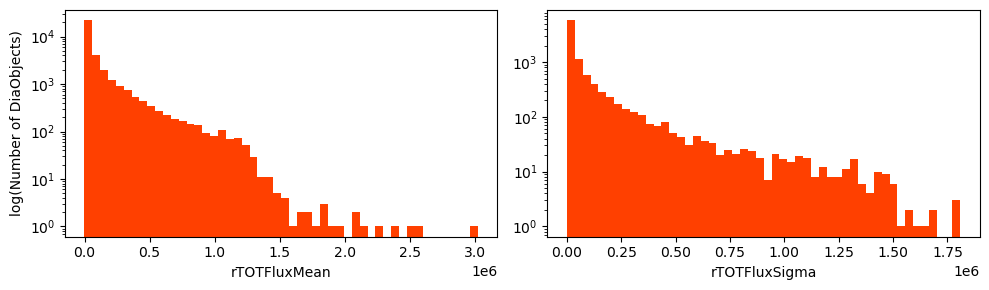

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['rTOTFluxMean'], bins=50, log=True, color=plot_filter_colors['r'])
ax[0].set_xlabel('rTOTFluxMean')
ax[0].set_ylabel('log(Number of DiaObjects)')

ax[1].hist(DiaObjs['rTOTFluxSigma'], bins=50, log=True, color=plot_filter_colors['r'])
ax[1].set_xlabel('rTOTFluxSigma')

plt.tight_layout()
plt.show()

### 2.3. Investigate the DiaSource data for one random, bright, well-sampled DiaObject

Choose a DiaObject that was detected >40 times in an r-band difference image, had an average total (direct-image) flux > 1e6, and an average PS difference-image flux > 5e5.

In [15]:
tx = numpy.where((DiaObjs['rPSFluxNdata'] > 40)
                 & (DiaObjs['rTOTFluxMean'] > 1000000)
                 & (DiaObjs['rPSFluxMean'] > 500000))[0]

use_index = tx[0]
use_diaObjectId = DiaObjs['diaObjectId'][tx[0]]
del tx

Retrieve the DiaSource data for this DiaObject.

In [16]:
results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, ccdVisitId,"
                         "filterName, midPointTai, psFlux, totFlux, totFluxErr, "
                         "apFlux, apFluxErr,psFluxErr, snr  "
                         "FROM dp02_dc2_catalogs_frdf.DiaSource "
                         "WHERE diaObjectId = "+str(use_diaObjectId))

DiaSrcs = results.to_table()
del results

Sort the DiaSrcs table based on the mid-point time of the exposure, and create an array `fx` that indexes all observations obtained with the r-band filter.

In [17]:
DiaSrcs.sort('midPointTai')
fx = numpy.where(DiaSrcs['filterName'] == 'r')[0]
print('Number of r-band observations: ', len(fx))

Number of r-band observations:  42


**Plot the lightcurves for one DiaObject**

Plot the difference-image (PSFlux) and direct-image (TOTFlux) lightcurves. 
Mark the DiaObject minimum and maximum flux with solid lines; average flux with dashed lines; and the standard deviation in flux with dotted lines.

The purpose of this plot is to serve as a visual aid for understanding the lightcurve statistic summary parameters.

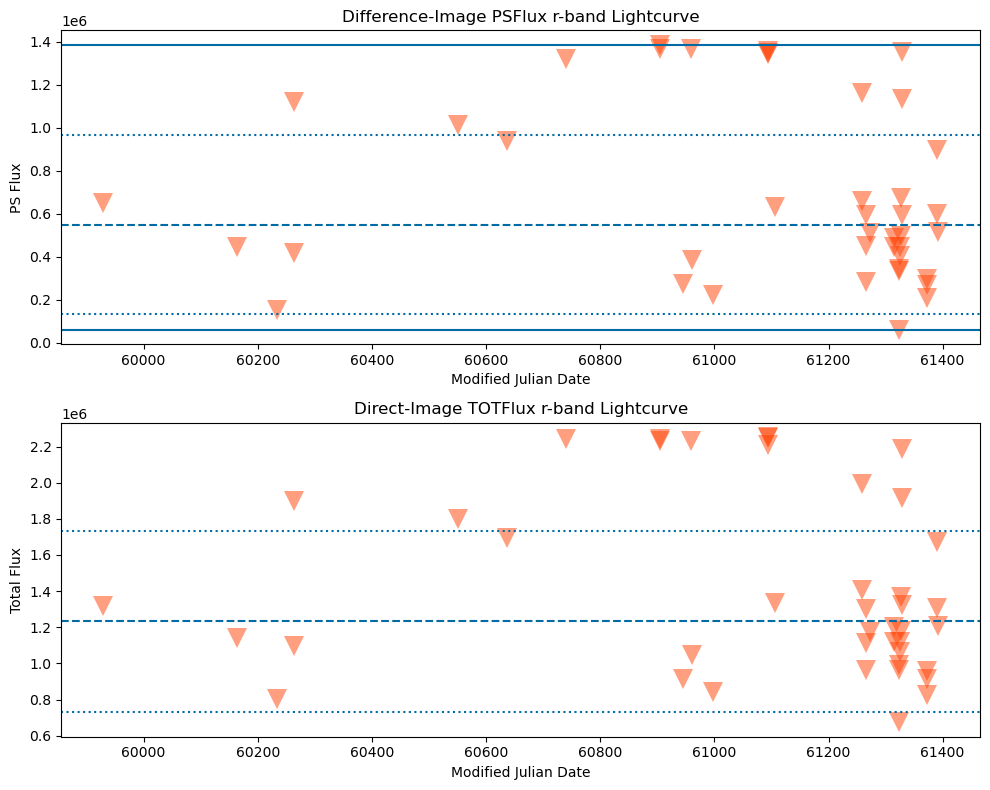

In [18]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharey=False, sharex=False)

ax[0].plot(DiaSrcs['midPointTai'][fx], DiaSrcs['psFlux'][fx],
           plot_filter_symbols['r'], ms=15, mew=0, alpha=0.5, color=plot_filter_colors['r'])
ax[0].axhline(DiaObjs['rPSFluxMin'][use_index])
ax[0].axhline(DiaObjs['rPSFluxMax'][use_index])
ax[0].axhline(DiaObjs['rPSFluxMean'][use_index], ls='dashed')
ax[0].axhline(DiaObjs['rPSFluxMean'][use_index] - DiaObjs['rPSFluxSigma'][use_index], ls='dotted')
ax[0].axhline(DiaObjs['rPSFluxMean'][use_index] + DiaObjs['rPSFluxSigma'][use_index], ls='dotted')
ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('PS Flux')
ax[0].set_title('Difference-Image PSFlux r-band Lightcurve')

ax[1].plot(DiaSrcs['midPointTai'][fx], DiaSrcs['totFlux'][fx],
           plot_filter_symbols['r'], ms=15, mew=0, alpha=0.5, color=plot_filter_colors['r'])
ax[1].axhline(DiaObjs['rTOTFluxMean'][use_index], ls='dashed')
ax[1].axhline(DiaObjs['rTOTFluxMean'][use_index] - DiaObjs['rTOTFluxSigma'][use_index], ls='dotted')
ax[1].axhline(DiaObjs['rTOTFluxMean'][use_index] + DiaObjs['rTOTFluxSigma'][use_index], ls='dotted')
ax[1].set_xlabel('Modified Julian Date')
ax[1].set_ylabel('Total Flux')
ax[1].set_title('Direct-Image TOTFlux r-band Lightcurve')

plt.tight_layout()
plt.show()

**Plot the distribution of flux measurements for one DiaObject**

Plot the distribution (left) and normalized cumulative distribution (right) of difference-image fluxes (PSFlux), along with the relevant DiaObject characterization parameters (e.g., mean, sigma, and percentiles).
Mark the average flux with dashed lines and the standard deviation in flux with dotted lines.

The purpose of this plot is to serve as a visual aid for understanding the lightcurve statistic summary parameters.

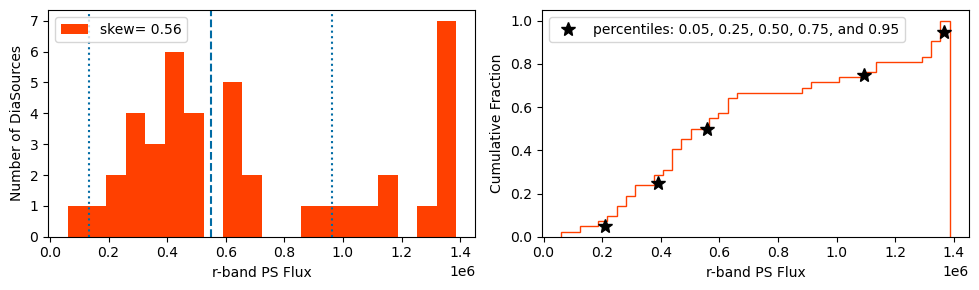

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaSrcs['psFlux'][fx], bins=20, color=plot_filter_colors['r'],
           label='skew=%5.2f' % DiaObjs['rPSFluxSkew'][use_index])
ax[0].axvline(DiaObjs['rPSFluxMean'][use_index], ls='dashed')
ax[0].axvline(DiaObjs['rPSFluxMean'][use_index] - DiaObjs['rPSFluxSigma'][use_index], ls='dotted')
ax[0].axvline(DiaObjs['rPSFluxMean'][use_index] + DiaObjs['rPSFluxSigma'][use_index], ls='dotted')
ax[0].set_xlabel('r-band PS Flux')
ax[0].set_ylabel('Number of DiaSources')
ax[0].legend(loc='upper left')

ax[1].hist(DiaSrcs['psFlux'][fx], bins=len(fx), color=plot_filter_colors['r'],
           cumulative=True, density=True, histtype='step')
ax[1].plot(DiaObjs['rPSFluxPercentile05'][use_index], 0.05, '*', ms=10, color='black',
           label='percentiles: 0.05, 0.25, 0.50, 0.75, and 0.95')
ax[1].plot(DiaObjs['rPSFluxPercentile25'][use_index], 0.25, '*', ms=10, color='black')
ax[1].plot(DiaObjs['rPSFluxPercentile50'][use_index], 0.50, '*', ms=10, color='black')
ax[1].plot(DiaObjs['rPSFluxPercentile75'][use_index], 0.75, '*', ms=10, color='black')
ax[1].plot(DiaObjs['rPSFluxPercentile95'][use_index], 0.95, '*', ms=10, color='black')
ax[1].set_xlabel('r-band PS Flux')
ax[1].set_ylabel('Cumulative Fraction')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

Clean up by deleting a few arrays that are no longer needed.

In [20]:
del DiaObjs, DiaSrcs, fx
del use_index, use_diaObjectId

## 3. Identify DiaObjects that are potential Type Ia Supernovae

For this example, a sample of ***potential*** low-redshift, well-sampled Type Ia supernovae (SNIa) are identified.

Compared to other types of supernovae, SNIa have homogenous lightcurves with very similar peak absolute brightnesses (about -19 mag in B-band), and similar rise and decline times (i.e., similar observed lightcurve amplitudes and durations, for a survey with a given limiting magnitude).

In LSST-like data sets with an r-band limiting magnitude of about 24.5 mag, such as the DC2 simulation, low-redshift SNIa (0.1 < _z_ < 0.3) lightcurves would look approximately like those plotted in the image below.

<img src="data/template_lowz_Vband.png" width=400>

In this example, the expected peak brightnesses, amplitude, and duration for the lightcurves of low-redshift SNIa are used to construct a TAP query on the DiaObjects table to identify a sample of ***potential*** SNIa.

> **Warning:** The following is a very rough, back-of-the-envelope way to identify a bunch of DiaObjects with parameters that suggest they are SNIa-like. The resulting sample is not scientifically useful (not pure, not complete) – it is just a few simple cuts that will get you a bunch of DiaObjects for which we can demonstrate how to plot lightcurves using the DiaSource table. Real SN-finding algorithms are photometric classifiers that fit the lightcurves with templates, rigorously, and provide probabilistic classifications. The text in Section 1 of the notebook describes this.

### 3.1. Establish lightcurve parameter constraints to identify potential SNIa

Define the desired redshift boundaries, the known approximate peak absolute magnitude for SNeIa (-19 mag), and the desired peak range to use to create the TAP query. This range roughly includes the intrinsic diversity in SNIa brightness and color, and host-galaxy reddening.

In [21]:
redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

Use the astropy.cosmology package to convert redshift to distance modulus. 
Define the minimum and maximum peak apparent r-band magnitudes -- allowing for the intrinsic diversity range specified above -- to use in the 
TAP query.

In [22]:
snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range
print('The minimum and maximum apparent r-band magnitudes '
      'to use in the TAP query are %5.2f and %5.2f mag.' %
      (snia_peak_mr_min, snia_peak_mr_max))

The minimum and maximum apparent r-band magnitudes to use in the TAP query are 18.82 and 22.46 mag.


Define maximum magnitudes in the g- and i-bands to use in the TAP query. The point of this is to simply enforce detection in at least the three filters g, r, and i. With knowledge of SNIa colors, this could be made more constraining, but for the purposes of this example these values are fine.

In [23]:
snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

Define the r-band minimum and maximum lightcurve amplitudes to use in the TAP query (i.e., the difference between the brightest and faintest detections in the difference image, in magnitudes). Well-sampled, low-redshift SNIa should be observed to change by at least 1.5 mag (_z_=0.3), and up to 5.5 mag (_z_=0.1).

In [24]:
snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

Define the minimum and maximum number of DiaSources (i.e., difference-image detections) to use in the TAP query.
The goal of this example is to identify potential _well-sampled_ Type Ia supernovae, and here a minimum of 15 detections is used.
Since the DC2 dataset was simulated using a baseline observing strategy (and does not include deep drilling fields), there are no more than 100 visits per year per field.
Any DiaObject with >100 DiaSources had a duration >1 year, and is not a SNIa.

In [25]:
snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

Define the minimum and maximum lightcurve duration, in days. 
The duration is the time between the first and last difference-image detection in any filter.
As seen in the template lightcurve plot above, SNIa at redshifts 0.1 < _z_ < 0.3 will have durations of 50 to 300 days.

In [26]:
snia_duration_min = 50
snia_duration_max = 300

> **Notice:** Of the above parameters defined to identify potential SNIa, only the lightcurve duration is _not_ represented in the DiaObjects table, and cannot be included as a constraint in the TAP query used below.
Instead, the lightcurve durations are calculated and used in Section 3.3.

### 3.2. Retrieve a sample of potentially SNIa-like DiaObjects

Only retrieve 1000 DiaObjects for this example.
When the TAP query completes, transfer the results to an astropy table.

This TAP query takes about a minute.

Note the use of the function `scisql_nanojanskyToAbMag` to retrieve magnitudes directly rather than having to convert them from fluxes after the query.

In [27]:
results = service.search("SELECT TOP 1000 "
                         "ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin "
                         "FROM dp02_dc2_catalogs_frdf.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ")

DiaObjs = results.to_table()
DiaObjs['rMagAmp'] = DiaObjs['rMagMin'] - DiaObjs['rMagMax']
del results

**Option**: display the table.

In [28]:
# DiaObjs

**Plot histograms of brightest magnitude and lightcurve amplitude**

Plot histograms to characterize the brightest detected r-band magnitudes (left) and the r-band amplitudes (right) for the DiaObjects in this initial sample of potentially SNIa-like time-domain objects.

Notice that the brightest r-band magnitude distribution (left) is bimodal, and that the distribution of r-band amplitudes declines until about 3.5 mag and then extends as a tail of brighter time-variable objects to amplitudes of 5.5 mag.
The underlying cause of both of these effects is likely the fact that the only time-variable sources in DC2 are stars (mostly brighter) and Type Ia supernovae (mostly fainter) -- but confirming this is left as an exercise for the learner.

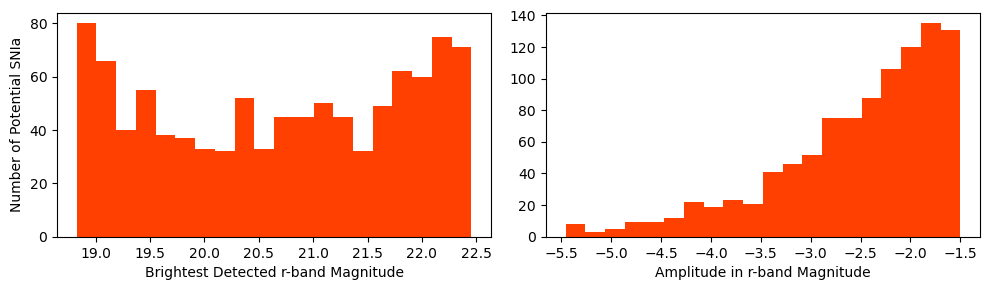

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['rMagMin'], bins=20, color=plot_filter_colors['r'])
ax[0].set_xlabel('Brightest Detected r-band Magnitude')
ax[0].set_ylabel('Number of Potential SNIa')

ax[1].hist(DiaObjs['rMagAmp'], bins=20, color=plot_filter_colors['r'])
ax[1].set_xlabel('Amplitude in r-band Magnitude')

plt.tight_layout()
plt.show()

### 3.3. Calculate lightcurve duration and identify potential SNIa

The lightcurve duration -- time between the first and last detected DiaSource in any filter -- is not included in the DiaObject table.
It is calculated below, using all of the DiaSources for each DiaObject.

Time is reported in the DiaSource table as `midPointTai`, which is in the SI unit of "TAI" (<a href="https://en.wikipedia.org/wiki/International_Atomic_Time">International Atomic Time</a>), and is presented in days (in particular, as "<a href="https://en.wikipedia.org/wiki/Julian_day">Modified Julian Days</a>").

First, create a string list of the `diaObjectId` that is formatted like "(1249546586455802795, 1248684569339625641, 1248684569339626125)".

In [30]:
all_ids = DiaObjs['diaObjectId']
temp_list = '('
for i, id in enumerate(all_ids):
    temp_list = temp_list + str(id)
    if i < len(all_ids)-1:
        temp_list = temp_list + ', '
    elif i == len(all_ids)-1:
        temp_list = temp_list + ')'

Option to print the 1000-element long list.

In [31]:
# print(temp_list)

Retrieve the `midPointTai` for all observations (`diaSource`s) for all the `diaObject`s.

In [32]:
results = service.search("SELECT diaObjectId, midPointTai "
                         "FROM dp02_dc2_catalogs_frdf.DiaSource "
                         "WHERE diaObjectId IN " + temp_list)
results = results.to_table()

Calculate the durations for each `diaObject` and add them to the `DiaObjs` table.

In [33]:
DiaObjs['duration'] = numpy.zeros(len(DiaObjs), dtype='float')

for j, DiaObjId in enumerate(DiaObjs['diaObjectId']):
    tx = numpy.where(results['diaObjectId'] == DiaObjId)[0]
    DiaObjs['duration'][j] = numpy.max(results['midPointTai'][tx]) - numpy.min(results['midPointTai'][tx])
    del tx

Clean up.

In [34]:
del results

Select only DiaObjects that have lightcurve durations within the specified range for SNIa.

In [35]:
tx = numpy.where((DiaObjs['duration'] > snia_duration_min)
                 & (DiaObjs['duration'] < snia_duration_max))[0]
print(len(tx))

42


**Plot a histogram of lightcurve durations, and a scatter plot of duration vs. amplitude, for the potential SNIa**

Plot a histogram of lightcurve durations (left) and a plot of duration versus r-band amplitude (right) to further characterize this sample of potential SNIa. 

Notice the spread in duration, and how it is correlated with lightcurve amplitude, as expected for SNIa. 

Tracking down the origin of the two outliers is left as an exercise for the learner: if they are truly SNIa observed for >100 days, then they should have a brighter amplitude.

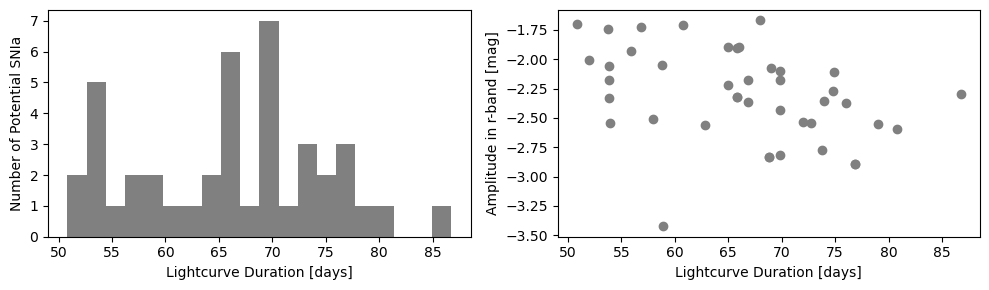

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['duration'][tx], bins=20, color='gray')
ax[0].set_xlabel('Lightcurve Duration [days]')
ax[0].set_ylabel('Number of Potential SNIa')

ax[1].plot(DiaObjs['duration'][tx], DiaObjs['rMagAmp'][tx], 'o', color='gray')
ax[1].set_xlabel('Lightcurve Duration [days]')
ax[1].set_ylabel('Amplitude in r-band [mag]')

plt.tight_layout()
plt.show()

### 3.4. Plot multi-band lightcurves for the first 20 potential SNIa

Notice that all of these lightcurves do resemble Type Ia supernovae!
That is a promising sign that the methodology of using the DiaObject summary parameters, along with the lightcurve duration (which must be calculate separately), can identify an initial sample of potential SNIa.

> **Keep in mind that this is not necessarily a pure or complete sample of SNIa,** just a sample of *potential well-sampled low-redshift* SNIa - decent enough to use as a demonstration, or a starting point for a more rigorous classification process.
Different science goals will have different requirements on sample identification.

Below, the lightcurves plotted are based on the signal-to-noise ratio > 5 detections from the DiaSource table only.
In Section 4, lightcurves based on forced photometry are used instead.

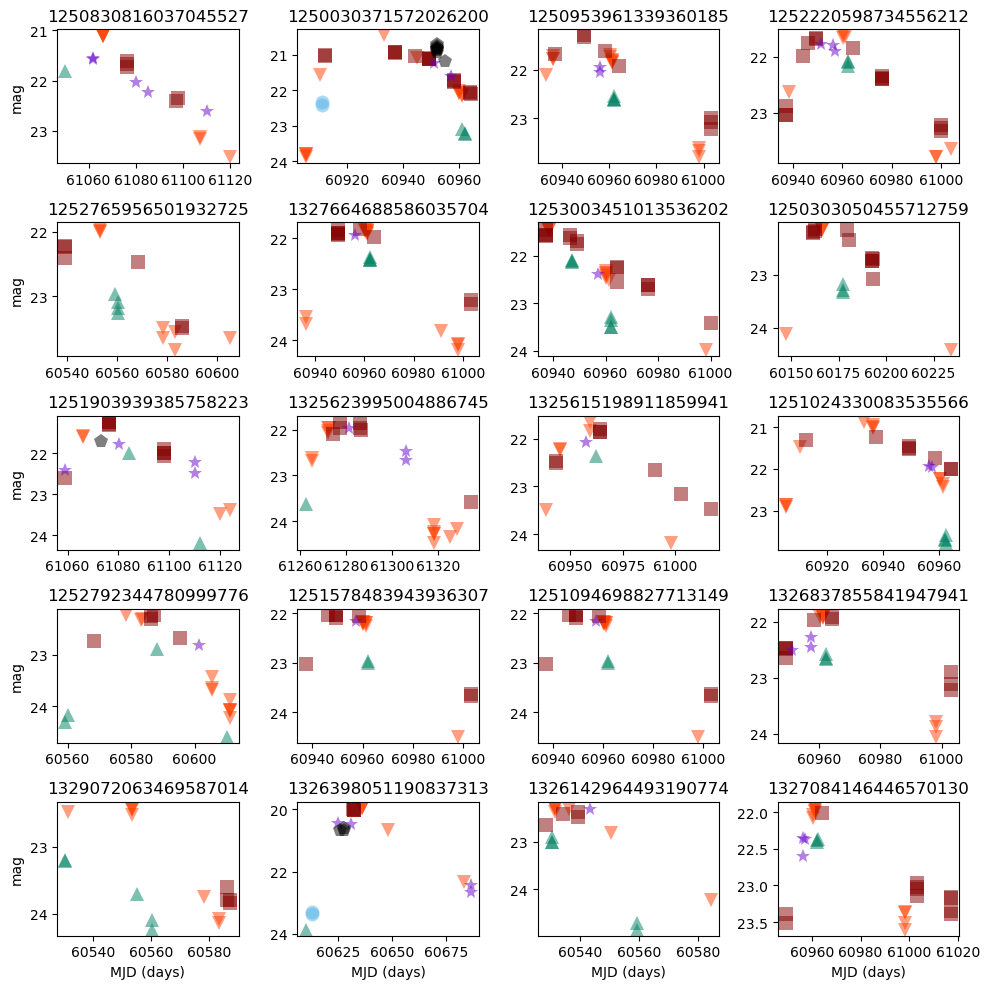

In [37]:
fig, ax = plt.subplots(5, 4, figsize=(10, 10), sharey=False, sharex=False)

x = 0

for i in range(5):
    for j in range(4):
        results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                                 "filterName, midPointTai, "
                                 "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                                 "FROM dp02_dc2_catalogs_frdf.DiaSource "
                                 "WHERE diaObjectId = "+str(DiaObjs['diaObjectId'][tx[x]]))
        results = results.to_table()

        for f, filt in enumerate(plot_filter_labels):
            fx = numpy.where(results['filterName'] == filt)[0]
            ax[i, j].plot(results['midPointTai'][fx], results['psAbMag'][fx],
                          plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                          color=plot_filter_colors[filt])
            del fx

        ax[i, j].invert_yaxis()
        ax[i, j].set_title(DiaObjs['diaObjectId'][tx[x]])

        if i == 4:
            ax[i, j].xaxis.set_label_text('MJD (days)')
        if j == 0:
            ax[i, j].yaxis.set_label_text('mag')

        x += 1
        del results

plt.tight_layout()
plt.show()

## 4. Forced photometry lightcurves

Above, the DiaSource table is used to plot lightcurves, but it only includes SNR>5 detections in the difference images.
If your science goal requires lower-SNR measurements, use the forced photometry in the ForcedSourceOnDiaObjects table instead, as demonstrated below.

Let's say there is a specific object whose lightcurve looks particularly interesting. In order to explore the flux of the object in all sets of differences images (not just those with detected sources), the ForcedSourceOnDiaObject catalog can be utilized. 

**ForcedSourceOnDiaObject Table**: point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the `DiaObject` table.

For more information, see <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#ForcedSourceOnDiaObject">the schema of the ForcedSourceOnDiaObject catalog</a>.

**Option**: print all of the available column names and descriptions for the ForcedSourceOnDiaObject table.

In [38]:
# results = service.search("SELECT column_name, description from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs_frdf.ForcedSourceOnDiaObject'")
# for column_name, description in zip(results['column_name'], results['description']):
#     print(column_name, '-', description)

### 4.1. Retrieve photometry for a DiaObject

As an example, let's look at the forced photometry on the difference images of the object 1250953961339360185, which has an interesting lightcurve. Note that it is unlikely this object is shown in the 20 SNIa candidates above since they will change every time the search is run. That object should however be in the list of 1000 SNIa candidates that we started with.

In [39]:
DiaObjID = 1250953961339360185
print(DiaObjID)

1250953961339360185


Here, we will define the query to extract the information from the ForcedSourceOnDiaObject table on our DiaObject of interest in order to construct a lightcurve that includes forced photometry (i.e., sub-threshold measurements with SNR<5).

Below, a JOIN to the CcdVisit table is used to obtain the exposure time mid-point in modified julian date (MJD) format (expMidptMJD), which is necessary to construct the lightcurve.

The ForcedSourceOnDiaObject contains forced photometry on both the difference image (psfDiffFlux, psfDiffFluxErr) and the processed visit image (PVI), also called the "direct" image (psfFlux, psfFluxErr).
Both types of fluxes are retrieved below for our DiaObject of interest.

This query should take less than a second.

In [40]:
results = service.search("SELECT fsodo.coord_ra, fsodo.coord_dec, "\
                         "fsodo.diaObjectId, fsodo.ccdVisitId, fsodo.band, "\
                         "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                         "fsodo.psfFlux, fsodo.psfFluxErr, "\
                         "cv.expMidptMJD "\
                         "FROM dp02_dc2_catalogs_frdf.ForcedSourceOnDiaObject as fsodo "\
                         "JOIN dp02_dc2_catalogs_frdf.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                         "WHERE fsodo.diaObjectId = "+str(DiaObjID))

Save the results in a table "FrcdSrc" (short for forced source, to distinguish it from the results from DiaSource saved as DiaSrc, below).

In [41]:
FrcdSrc = results.to_table()
FrcdSrc
del results

Also retrieve the DiaSource measurements for the DiaObject of interest.
Recall that this will only return flux measurements from the difference images with SNR>5 detection.

This should also take less than a second.

In [42]:
results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, "
                         "filterName, midPointTai, SNR, ccdVisitId, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs_frdf.DiaSource "
                         "WHERE diaObjectId = "+str(DiaObjID))
DiaSrc = results.to_table()
del results

Unlike the DiaSource catalog, the ForcedSourceOnDiaObject catalog does not provide the SNR for the flux measurements. Since it provides a useful diagnostic, we define 'diffSNR' for our object by the ratio of the absolute value of 'psfDiffFlux' and 'psfDiffFluxErr.'

In [43]:
FrcdSrc['DiffSNR'] = abs(FrcdSrc['psfDiffFlux']/FrcdSrc['psfDiffFluxErr'])

Show that the DiffSNR column has been added to our "FrcdSrc" table.

In [44]:
FrcdSrc

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD,DiffSNR
deg,deg,,,,nJy,nJy,nJy,nJy,d,
float64,float64,int64,int64,object,float64,float64,float64,float64,float64,float64
60.2901401,-44.142051,1250953961339360185,688121184,z,--,--,--,--,60598.1694092,--
60.2901401,-44.142051,1250953961339360185,688121184,z,--,--,--,--,60598.1694092,--
60.2901401,-44.142051,1250953961339360185,688323004,z,--,--,--,--,60598.2610902,--
60.2901401,-44.142051,1250953961339360185,688323004,z,--,--,--,--,60598.2610902,--
60.2901401,-44.142051,1250953961339360185,688237049,z,--,--,--,--,60598.2216632,--
60.2901401,-44.142051,1250953961339360185,688237049,z,--,--,--,--,60598.2216632,--
60.2901401,-44.142051,1250953961339360185,712268050,z,--,--,--,--,60631.0857602,--
60.2901401,-44.142051,1250953961339360185,712268050,z,--,--,--,--,60631.0857602,--


### 4.2. Plot the lightcurves

For our DiaObject of interest, compare the lightcurves that include forced photometry from the ForcedSourceOnDiaObject table (open markers, left plots) with lightcurves that include only SNR>5 detections from the DiaSource table (filled markers, right plots).

> **Notice**: The forced photometry lightcurves (left) include flux measurements from before and after the source was identified in the DIAsource catalogs. The shaded gray regions indicate the dates spanned by the detections only (DiaSources only).

Define the MJD ranges for the "full" lightcurve from the forced photometry, and for the "detected" part of the lightcurve from the DiaSource table.

In [45]:
mjd_full_start = numpy.min(FrcdSrc['expMidptMJD'])
mjd_full_end = numpy.max(FrcdSrc['expMidptMJD'])

mjd_det_start = numpy.min(DiaSrc['midPointTai'])
mjd_det_end = numpy.max(DiaSrc['midPointTai'])

#### 4.2.1. Lightcurve for the full survey

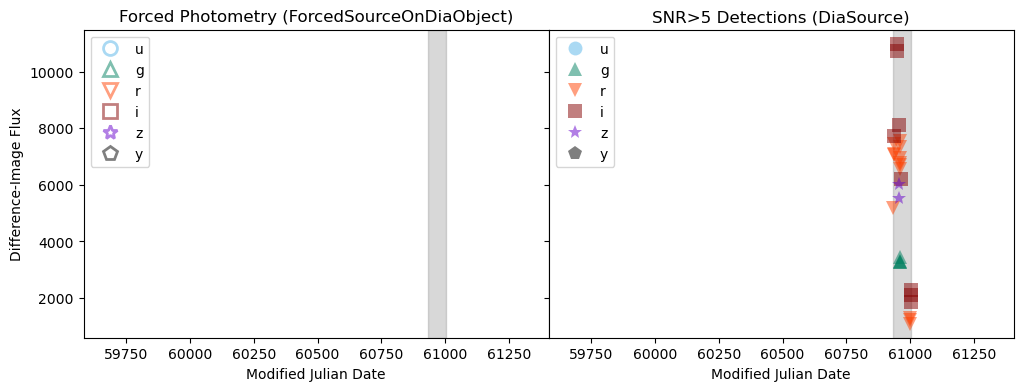

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(FrcdSrc['band'] == filt)[0]
    ax[0].plot(FrcdSrc['expMidptMJD'][fx], FrcdSrc['psfDiffFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
               alpha=0.5, color='none', label=filt)
    del fx

ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('Difference-Image Flux')
ax[0].set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax[0].set_xlim(mjd_full_start, mjd_full_end)
ax[0].legend(loc='upper left')
ax[0].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(DiaSrc['filterName'] == filt)[0]
    ax[1].plot(DiaSrc['midPointTai'][fx], DiaSrc['psFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=0, color=plot_filter_colors[filt],
               alpha=0.5, label=filt)
    del fx

ax[1].set_xlabel('Modified Julian Date')
ax[1].set_title('SNR>5 Detections (DiaSource)')
ax[1].set_xlim(mjd_full_start, mjd_full_end)
ax[1].legend(loc='upper left')
ax[1].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.subplots_adjust(wspace=.0)

plt.show()

#### 4.2.2. Lightcurve for epochs with SNR>5 detections

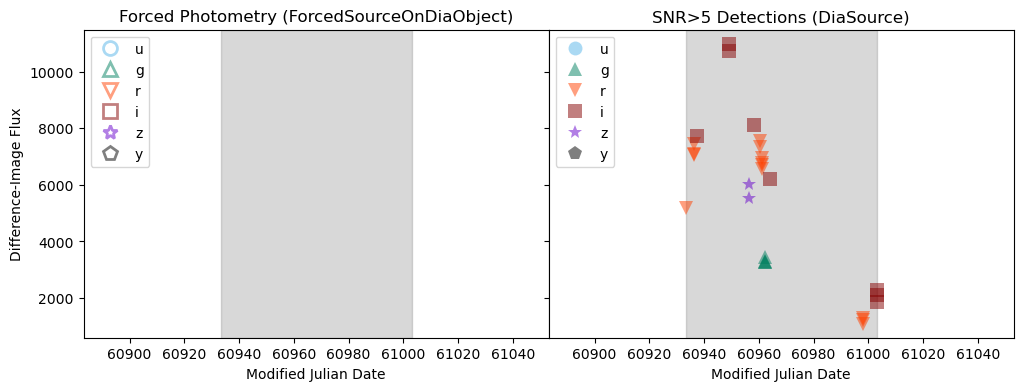

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(FrcdSrc['band'] == filt)[0]
    ax[0].plot(FrcdSrc['expMidptMJD'][fx], FrcdSrc['psfDiffFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
               alpha=0.5, color='none', label=filt)
    del fx
ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('Difference-Image Flux')
ax[0].set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax[0].set_xlim(mjd_det_start-50, mjd_det_end+50)
ax[0].legend(loc='upper left')
ax[0].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(DiaSrc['filterName'] == filt)[0]
    ax[1].plot(DiaSrc['midPointTai'][fx], DiaSrc['psFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=0, color=plot_filter_colors[filt],
               alpha=0.5, label=filt)
    del fx

ax[1].set_xlabel('Modified Julian Date')
ax[1].set_title('SNR>5 Detections (DiaSource)')
ax[1].set_xlim(mjd_det_start-50, mjd_det_end+50)
ax[1].legend(loc='upper left')
ax[1].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.subplots_adjust(wspace=.0)

plt.show()

> **Notice**: In the above plots, the forced photometry (psfDiffFlux from ForcedSourceOnDiaObject, open symbols, left panels) is nearly identical to the detection photometry (psFlux from DiaSource, filled symbols, right panels), but the ForcedSourceOnDiaObject contains additional measurements from epochs in which the source in the difference image had a SNR<5. No such cutoff is applied to the ForcedSourceOnDiaObject catalog, in which photometry from all visits is included.

### 4.3. Identify "missing measurements" from SNR<5 epochs

Within the "gray zone" above (defined by epochs in which the source was detected with SNR>5 in the difference images), identify how many measurements there are in the DiaSource and ForcedSourceOnDiaObject tables, and compare.

In [48]:
cov = numpy.where((FrcdSrc['expMidptMJD'] >= mjd_det_start)
                  & (FrcdSrc['expMidptMJD'] <= mjd_det_end))

print('Within the date range of SNR>5 detections, there were:')
print(len(DiaSrc), 'measurements in DiaSource catalog of %.i' % (DiaObjID))
print(len(FrcdSrc[cov]), 'measurements in ForcedSourceOnDiaObject catalog of %.i' % (DiaObjID))

Within the date range of SNR>5 detections, there were:
27 measurements in DiaSource catalog of 1250953961339360185
80 measurements in ForcedSourceOnDiaObject catalog of 1250953961339360185


Identify only the SNR<5 measurements from the ForcedSourceOnDiaObject table by looking for unique "ccdVisitId" values that are not in the DiaSource results.
Note that we are still applying the condition where the measurements are taken within the date range of the DiaSource detections.

First, identify the unique visit IDs.

In [49]:
UniqueVID = set(FrcdSrc[cov]['ccdVisitId']) - set(DiaSrc['ccdVisitId'])

Next, construct a table of ForcedSourceOnDiaObject "missing measurements" that are not in the DiaSource catalog

In [50]:
UniqueObj = []
for x in UniqueVID:
    UniqueObj += numpy.where(FrcdSrc['ccdVisitId'] == x)
UniqueObj = numpy.concatenate(UniqueObj)

Inspect the table of "missing measurements".

In [51]:
FrcdSrc[UniqueObj]

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD,DiffSNR
deg,deg,,,,nJy,nJy,nJy,nJy,d,
float64,float64,int64,int64,object,float64,float64,float64,float64,float64,float64
60.2901401,-44.142051,1250953961339360185,960109025,g,--,--,--,--,60993.0627302,--
60.2901401,-44.142051,1250953961339360185,960109025,g,--,--,--,--,60993.0627302,--
60.2901401,-44.142051,1250953961339360185,948985095,u,--,--,--,--,60970.1579432,--
60.2901401,-44.142051,1250953961339360185,948985095,u,--,--,--,--,60970.1579432,--
60.2901401,-44.142051,1250953961339360185,936368072,y,--,--,--,--,60952.1606072,--
60.2901401,-44.142051,1250953961339360185,936368072,y,--,--,--,--,60952.1606072,--
60.2901401,-44.142051,1250953961339360185,936421079,y,--,--,--,--,60952.1842852,--
60.2901401,-44.142051,1250953961339360185,936421079,y,--,--,--,--,60952.1842852,--


Finally, verify why these "missing measurements" are not in the DiaSource catalog (their SNR is <5) by printing the maximum SNR.

In [52]:
numpy.max(FrcdSrc[UniqueObj]['DiffSNR'])

masked

### 4.4. Investigate potential SNR<5 variability

Going back to the forced photometry lightcurve of our object of interest, it looked like there may have been some past variability in the z band (purple star) at around MJD 60250. Let's investigate this point. **This is for demonstration purposes only since there are no simulated precursor outbursts for the supernovae in DP0.2**. 

Let's check if it is at least greater than 3$\sigma$ of the baseline (median) measurements using "sigma_clipped_stats".

Define the filter in which flaring (precursor activity) is investigated.

In [53]:
flare_filt = 'z'

Specify the median and standard deviation in the "flare" filter band for the flux measurements.

In [54]:
_, med, std = sigma_clipped_stats(FrcdSrc['psfDiffFlux'][numpy.where(FrcdSrc['band'] == flare_filt)[0]])

In [55]:
print('Median psfDiffFlux for all z-band forced sources: ', med, FrcdSrc['psfDiffFlux'].unit)
print('Standard deviation in psfDiffFlux for all z-band forced sources: ',std, FrcdSrc['psfDiffFlux'].unit)

Median psfDiffFlux for all z-band forced sources:  -- nJy
Standard deviation in psfDiffFlux for all z-band forced sources:  -- nJy


Define where any outlier variability (above 3$\sigma$) might be in the "flare" band, BEFORE or AFTER the "gray zone" defined by the epochs in which our DiaObject of interest was detected with SNR>5 in any filter.

First, index the flare-band epochs "before" and "after" within FrcdSrc.

In [56]:
ex = numpy.where(((FrcdSrc['expMidptMJD'] < mjd_det_start)
                  | (FrcdSrc['expMidptMJD'] > mjd_det_end))
                 & (FrcdSrc['band'] == flare_filt))[0]
print(len(ex))

154


Next, index which of _these_ is >3$\sigma$.

In [57]:
ix = numpy.where(FrcdSrc['psfDiffFlux'][ex] > med+3*std)[0]
print('Number of >3𝜎 z-band measurements (outside SNR>5 detections):',len(ix))

Number of >3𝜎 z-band measurements (outside SNR>5 detections): 0


Inspect the single >3$\sigma$ measurement in the forced photometry that occurred outside of the "gray zone".

**As a reminder, 3$\sigma$ is defined from the distribution of forced photometry measurements and is _not_ the photometric signal-to-noise ratio (i.e., DiffSNR)**.

In [58]:
FrcdSrc[ex[ix]]

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD,DiffSNR
deg,deg,,,,nJy,nJy,nJy,nJy,d,
float64,float64,int64,int64,object,float64,float64,float64,float64,float64,float64


**Statistics check:** recall that $\pm 3\sigma$ encompasses 99.7% of values in a normally-distributed random sample. So out of the 77 z-band forced photometry measurements we could have reasonably expected 0.23 at the $\sigma$ > 3 level, and the fact that we found one is consistent with small-number statistics, i.e., consistent with noise.

**Again, since this is from DP0.2, we _know_ this "flaring activity" is just noise but we use it to demonstrate how the ForcedSourceOnDIAObject catalog can be applied to search for pre- or post-transient variability.**

As a final demonstration, plot the point(s) on the lightcurve that exceed 3$\sigma$ and are outside the DiaSource date coverage.
Below, we plot the 3$\sigma$ flux range in red and the apparent variability outlier(s) as a yellow-filled plot marker.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/matplotlib/cbook.py:1072: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/matplotlib/patches.py:1151: UserWarning: Warning: converting a masked element to nan.
  xy = np.asarray(xy)


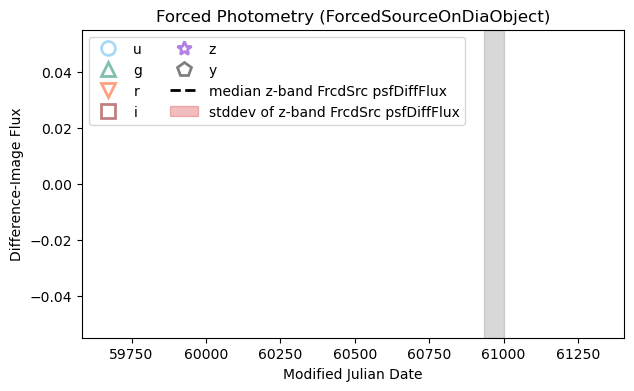

In [59]:
fig, ax = plt.subplots(figsize=(7, 4))

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(FrcdSrc['band'] == filt)[0]
    ax.plot(FrcdSrc['expMidptMJD'][fx], FrcdSrc['psfDiffFlux'][fx],
            plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
            alpha=0.5, color='none', label=filt)
    del fx

for i in ix:
    ax.plot(FrcdSrc['expMidptMJD'][ex[i]], FrcdSrc['psfDiffFlux'][ex[i]],
            plot_filter_symbols['z'], ms=14, mew=2, mec='black', alpha=1.0,
            color='yellow', label='z-band >3$\sigma$ FrcdSrc psfDiffFlux')

ax.hlines(y=med, xmin=numpy.min(FrcdSrc['expMidptMJD']), xmax=numpy.max(FrcdSrc['expMidptMJD']),
          linewidth=2, color='black', ls='--', label='median z-band FrcdSrc psfDiffFlux')
ax.axhspan(med, med+3*std, alpha=0.3, color='tab:red', label='stddev of z-band FrcdSrc psfDiffFlux')

ax.set_xlabel('Modified Julian Date')
ax.set_ylabel('Difference-Image Flux')
ax.set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax.legend(loc='upper left', ncol=2)
ax.set_xlim(mjd_full_start, mjd_full_end)
ax.axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.show()

## 5. Exercises for the learner

From here, there are a variety of exercises that a learner could undertake.

1. Change the query constraints and identify a sample of high-redshift SNIa.
2. Tighten the query contraints to identify only SNIa with pre-peak observations.
3. Add error bars to the lightcurves. Magnitude errors can be retrieved during a TAP survey with, e.g., `scisql_nanojanskyToAbMagSigma(psFlux, psFluxErr) as psAbMagErr`.
4. Apply a lightcurve-template fitter, or try a photometric classifier on the sample.
5. Investigate the forced source photometry lightcurves of other SNIa candidates.